# Introduction 

Notebook for testing and developing the Pandas solution for calculating the ticker statistics. This is done to speed things up for stat.py as a ticker by ticker solution is too slow. The code is not easy to understand, but the performance benefit is too big to ignore. dd. 2020/04/29.

In [1]:
import pandas as pd
import numpy as np
from util    import open_logfile, log, is_holiday, get_current_day_and_time
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta 

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
# put into util.py

def check_for_nulls(df):
    cols = list(df.columns)
    for c in cols:
        have_null = any(df[c].isna())
        if have_null == True:
            print(f"Column {c} has nulls")
    return "Finished checking..."

TRADE_FNM = '/Users/frkornet/Stockie/data/train_possible_trades.csv'

In [5]:
# incorporate into class Stats in stat.py

class Stats(object):
    def __init__(self):
        self.train_df = trades_df = pd.read_csv(TRADE_FNM)
        self.total_tickers = set(self.train_df.ticker.unique())
    
    def desired_stats(self):
        idx = self.train_df.dret > 0.5
        ddf = self.train_df.loc[idx].groupby(by='ticker')['dret'].count().reset_index()
        ddf.columns = [ 'ticker', 'cnt_desired']
        
        # create zeros for missing tickers -> edf
        tickers_to_add = list(self.total_tickers - self.desired_tickers)
        tlen = len(tickers_to_add)
        zero_list_int   = [int(0)] * tlen

        t_dict = {'ticker'      : tickers_to_add, 
                  'cnt_desired' : zero_list_int
                 }
        edf = pd.DataFrame(t_dict)

        #concatenate gdf and edf -> gdf
        self.ddf = pd.concat([ddf, edf])        
    
    def gain_stats(self):
        # group by ticker and calculate stats -> tdf
        aggs=['count', 'min', 'max', 'std', 'mean', 'sum']
        tdf = self.gain_df.groupby(by='ticker').agg(aggs)[['gain_pct', 'trading_days']].reset_index()
        tdf.columns=['ticker', 'cnt_gain', 'min_pct_gain', 'max_pct_gain', 'std_pct_gain', 
                     'mean_pct_gain', 'sum_pct_gain',
                     'cnt_trading_days', 'min_trading_days', 'max_trading_days', 'std_trading_days',
                     'mean_day_gain', 'sum_day_gain']

        # set null for std_pct_gain to zero in case there is only 1 row for ticker
        idx = tdf.std_pct_gain.isna() == True
        tdf.std_pct_gain.loc[idx] = 0

        # calculate return per ticker -> rdf
        rdf = self.gain_df.groupby(by='ticker')['ret'].prod().reset_index()
        rdf.columns=['ticker', 'ret']

        # inner join join gdf and rdf -> gdf
        gdf = pd.merge(left=tdf, right=rdf, on='ticker', how='inner')
        gdf['gain_daily_ret'] = round((gdf.ret ** (1/gdf.sum_day_gain) - 1) * 100, 2)

        # only keep needed columns
        cols_to_keep = ['ticker', 'cnt_gain', 'min_pct_gain', 'max_pct_gain', 'std_pct_gain', 'mean_pct_gain',
                        'mean_day_gain', 'gain_daily_ret']
        gdf = gdf[cols_to_keep]

        # create zeros for missing tickers -> edf
        tickers_to_add = list(self.total_tickers - self.gain_tickers)
        tlen = len(tickers_to_add)
        zero_list_float = [0.0] * tlen
        zero_list_int   = [int(0)] * tlen

        t_dict = {'ticker'         : tickers_to_add, 
                  'cnt_gain'       : zero_list_int,
                  'min_pct_gain'   : zero_list_float,
                  'max_pct_gain'   : zero_list_float,
                  'std_pct_gain'   : zero_list_float,
                  'mean_pct_gain'  : zero_list_float,
                  'mean_day_gain'  : zero_list_float,
                  'gain_daily_ret' : zero_list_float
                 }
        edf = pd.DataFrame(t_dict)

        #concatenate gdf and edf -> gdf
        gdf = pd.concat([gdf, edf])
        self.desired_stats()
        self.gdf = pd.merge(left=gdf, right=self.ddf, on='ticker', how='inner')

    def loss_stats(self):
        # group by ticker and calculate stats -> tdf
        aggs=['count', 'min', 'max', 'std', 'mean', 'sum']
        tdf = self.loss_df.groupby(by='ticker').agg(aggs)[['gain_pct', 'trading_days']].reset_index()
        tdf.columns=['ticker', 'cnt_loss', 'min_pct_loss', 'max_pct_loss', 'std_pct_loss', 'mean_pct_loss',
                     'sum_pct_loss',
                     'cnt_trading_days', 'min_trading_days', 'max_trading_days', 'std_trading_days',
                     'mean_day_loss', 'sum_day_loss']

        # set null for std_pct_gain to zero in case there is only 1 row for ticker
        idx = tdf.std_pct_loss.isna() == True
        tdf.std_pct_loss.loc[idx] = 0

        # calculate return per ticker -> rdf
        rdf = self.loss_df.groupby(by='ticker')['ret'].prod().reset_index()
        rdf.columns=['ticker', 'ret']

        # inner join join gdf and rdf -> gdf
        ldf = pd.merge(left=tdf, right=rdf, on='ticker', how='inner')
        ldf['loss_daily_ret'] = round((ldf.ret ** (1/ldf.sum_day_loss) - 1) * 100, 2)

        # only keep needed columns
        cols_to_keep = ['ticker', 'cnt_loss', 'min_pct_loss', 'max_pct_loss', 'std_pct_loss', 'mean_pct_loss',
                        'mean_day_loss', 'loss_daily_ret']
        ldf = ldf[cols_to_keep]

        # create zeros for missing tickers -> edf
        tickers_to_add = list(self.total_tickers - self.loss_tickers)
        tlen = len(tickers_to_add)
        zero_list_float = [0.0] * tlen
        zero_list_int   = [int(0)] * tlen

        t_dict = {'ticker'         : tickers_to_add, 
                  'cnt_loss'       : zero_list_int,
                  'min_pct_loss'   : zero_list_float,
                  'max_pct_loss'   : zero_list_float,
                  'std_pct_loss'   : zero_list_float,
                  'mean_pct_loss'  : zero_list_float,
                  'mean_day_loss'  : zero_list_float,
                  'loss_daily_ret' : zero_list_float
                 }
        edf = pd.DataFrame(t_dict)

        #concatenate gdf and edf -> gdf
        self.ldf = pd.concat([ldf, edf], sort=False)

    def zero_stats(self):
        # group by ticker and calculate stats -> tdf
        aggs=['count', 'mean']
        tdf = self.zero_df.groupby(by='ticker').agg(aggs)[['trading_days']].reset_index()
        tdf.columns=['ticker', 'cnt_zero', 'mean_day_zero']

        # create zeros for missing tickers -> edf
        tickers_to_add = list(self.total_tickers - self.zero_tickers)
        tlen = len(tickers_to_add)
        zero_list_float = [0.0] * tlen
        zero_list_int   = [int(0)] * tlen

        t_dict = {'ticker'         : tickers_to_add, 
                  'cnt_zero'       : zero_list_int,
                  'mean_day_zero'  : zero_list_float
                 }
        edf = pd.DataFrame(t_dict)

        #concatenate gdf and edf -> gdf
        self.zdf = pd.concat([tdf, edf], sort=False)

    def total_stats(self):
        # group by ticker and calculate stats -> tdf
        aggs=['count', 'sum', 'mean']
        tdf = self.train_df.groupby(by='ticker').agg(aggs)[['trading_days']].reset_index()
        tdf.columns=['ticker', 'total_cnt', 'total_days', 'mean_day']

        # calculate return per ticker -> rdf
        rdf = self.train_df.groupby(by='ticker')['ret'].prod().reset_index()
        rdf.columns=['ticker', 'ret']

        # inner join join gdf and rdf -> gdf
        tdf = pd.merge(left=tdf, right=rdf, on='ticker', how='inner')
        tdf['daily_ret'] = round((tdf.ret ** (1/tdf.total_days) - 1) * 100, 2)

        # only keep needed columns
        cols_to_keep = ['ticker', 'total_cnt', 'total_days', 'mean_day', 'daily_ret']
        self.tdf = tdf[cols_to_keep]
        
    def create_stats(self):
        self.train_df['gain']     = self.train_df.sell_close - self.train_df.buy_close
        self.train_df['pct_gain'] = (self.train_df.gain / self.train_df.buy_close) * 100
        self.train_df['ret']  = 1 + self.train_df['pct_gain']/100
        self.train_df['dret'] = round(self.train_df.ret ** (1/self.train_df.trading_days) - 1, 2)*100

        self.gain_df = self.train_df.loc[self.train_df.gain >  0]
        self.desired_df = self.train_df.loc[self.train_df.dret >  0.5]
        self.loss_df = self.train_df.loc[self.train_df.gain <  0]
        self.zero_df = self.train_df.loc[self.train_df.gain == 0]
        
        self.gain_tickers = set(self.gain_df.ticker.unique())
        self.desired_tickers = set(self.desired_df.ticker.unique())
        self.loss_tickers = set(self.loss_df.ticker.unique())
        self.zero_tickers = set(self.zero_df.ticker.unique())
        
        self.gain_stats()
        print("ddf:", len(self.ddf))
        print("gdf:", len(self.gdf))
        self.loss_stats()
        print("ldf:", len(self.ldf))
        self.zero_stats()
        print("zdf:", len(self.zdf))
        self.total_stats()
        print("tdf:", len(self.tdf))
        
        cdf = pd.merge(left=self.gdf, right=self.ldf, on='ticker', how='inner' )
        cdf = pd.merge(left=cdf, right=self.zdf, on='ticker', how='inner' )
        cdf = pd.merge(left=cdf, right=self.tdf, on='ticker', how='inner' )
        cdf['pct_desired'] = round((cdf.cnt_desired / cdf.total_cnt) * 100, 2)
        cdf['gain_ratio'] = round((cdf.cnt_gain / cdf.total_cnt) * 100, 2)
        cdf['good'] = 0
        self.df = cdf   
 

In [6]:
stats = Stats()

In [7]:
%time stats.create_stats()

ddf: 2726
gdf: 2726
ldf: 2726
zdf: 2726
tdf: 2726
CPU times: user 2.93 s, sys: 34.8 ms, total: 2.96 s
Wall time: 2.18 s


In [8]:
len(stats.train_df)

36732

In [9]:
len(stats.train_df.ticker.unique())

2726

In [10]:
stats.df

,ticker,cnt_gain,min_pct_gain,max_pct_gain,std_pct_gain,mean_pct_gain,mean_day_gain,gain_daily_ret,cnt_desired,cnt_loss,...,loss_daily_ret,cnt_zero,mean_day_zero,total_cnt,total_days,mean_day,daily_ret,pct_desired,gain_ratio,good
0,A,10,0.19,20.47,6.790346,7.014000,64.000000,0.10,1,6,...,-0.08,0,0.0,16,948,59.250000,0.04,6.25,62.50,0
1,AA,10,0.92,51.91,18.939379,17.286000,56.400000,0.26,1,7,...,-0.27,0,0.0,17,871,51.235294,0.07,5.88,58.82,0
2,AAL,8,1.41,35.69,14.307047,18.563750,64.625000,0.25,2,8,...,-0.19,0,0.0,16,929,58.062500,0.06,12.50,50.00,0
3,AAMC,6,0.57,109.18,40.893681,29.638333,32.833333,0.69,4,8,...,-1.01,0,0.0,14,557,39.785714,-0.41,28.57,42.86,0
4,AAME,10,1.75,29.23,9.337475,10.271000,41.800000,0.23,2,7,...,-0.12,0,0.0,17,959,56.411765,0.03,11.76,58.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,PROS,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0,1,...,-0.39,0,0.0,1,20,20.000000,-0.39,0.00,0.00,0
2722,SAIL,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0,3,...,-0.66,0,0.0,3,143,47.666667,-0.66,0.00,0.00,0
2723,LOVE,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0,3,...,-1.24,0,0.0,3,130,43.333333,-1.24,0.00,0.00,0
2724,VREX,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,0,5,...,-0.39,0,0.0,5,247,49.400000,-0.39,0.00,0.00,0


In [11]:
stats.df.pct_desired.describe()

count    2726.000000
mean        8.925609
std        12.226344
min         0.000000
25%         0.000000
50%         5.880000
75%        13.330000
max       100.000000
Name: pct_desired, dtype: float64

In [16]:
for c in sorted(stats.df.columns):
    has_nulls = any(stats.df[c].isna())
    tabs="\t"
    if len(c) < 7:
        tabs = tabs + '\t'
    print(c, tabs, has_nulls)

cnt_desired 	 False
cnt_gain 	 False
cnt_loss 	 False
cnt_zero 	 False
daily_ret 	 False
gain_daily_ret 	 False
gain_ratio 	 False
good 		 False
loss_daily_ret 	 False
max_pct_gain 	 False
max_pct_loss 	 False
mean_day 	 False
mean_day_gain 	 False
mean_day_loss 	 False
mean_day_zero 	 False
mean_pct_gain 	 False
mean_pct_loss 	 False
min_pct_gain 	 False
min_pct_loss 	 False
pct_desired 	 False
std_pct_gain 	 False
std_pct_loss 	 False
ticker 		 False
total_cnt 	 False
total_days 	 False


In [49]:
idx = (stats.df.daily_ret  > 0.0) \
    & (stats.df.pct_desired > 10) \
    & (stats.df.mean_day < 100)
len(stats.df), len(stats.df.loc[idx])

(2726, 505)

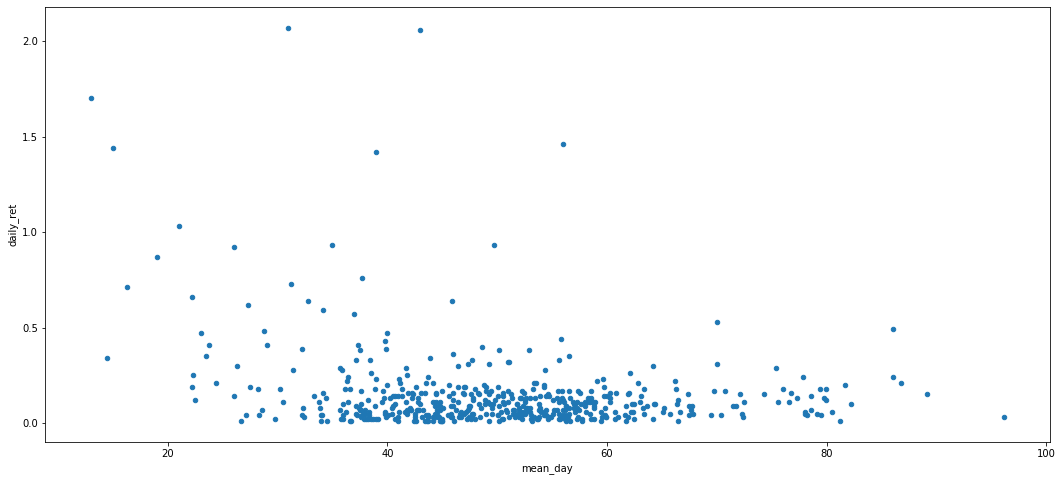

In [51]:
stats.df.loc[idx].plot(x='mean_day', y='daily_ret', kind='scatter', figsize=(18,8))

In [52]:
stats.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2726 entries, 0 to 2725
Data columns (total 25 columns):
ticker            2726 non-null object
cnt_gain          2726 non-null int64
min_pct_gain      2726 non-null float64
max_pct_gain      2726 non-null float64
std_pct_gain      2726 non-null float64
mean_pct_gain     2726 non-null float64
mean_day_gain     2726 non-null float64
gain_daily_ret    2726 non-null float64
cnt_desired       2726 non-null int64
cnt_loss          2726 non-null int64
min_pct_loss      2726 non-null float64
max_pct_loss      2726 non-null float64
std_pct_loss      2726 non-null float64
mean_pct_loss     2726 non-null float64
mean_day_loss     2726 non-null float64
loss_daily_ret    2726 non-null float64
cnt_zero          2726 non-null int64
mean_day_zero     2726 non-null float64
total_cnt         2726 non-null int64
total_days        2726 non-null int64
mean_day          2726 non-null float64
daily_ret         2726 non-null float64
pct_desired       2726 non

In [53]:
stats.df.good = 0
stats.df.loc[idx, 'good'] = 1
sum(stats.df.loc[idx].good)

505

In [54]:
stats.df.pct_desired.describe()

count    2726.000000
mean        8.925609
std        12.226344
min         0.000000
25%         0.000000
50%         5.880000
75%        13.330000
max       100.000000
Name: pct_desired, dtype: float64

In [55]:
trades_df = pd.read_csv(TRADE_FNM)
trades_df['gain'] = trades_df.sell_close - trades_df.buy_close
trades_df['pct_gain'] = (trades_df.gain / trades_df.buy_close) * 100
trades_df['ret'] = 1 + trades_df['pct_gain']/100
print("checking trades_df:")
print(check_for_nulls(trades_df))

gain_df = trades_df.loc[trades_df.gain >  0]
print("checking gain_df:")
print(check_for_nulls(gain_df))

loss_df = trades_df.loc[trades_df.gain <  0]
print("checking loss_df:")
print(check_for_nulls(loss_df))

zero_df = trades_df.loc[trades_df.gain == 0]
print("checking zero_df:")
print(check_for_nulls(zero_df))

total_tickers = set(trades_df.ticker.to_list())
gain_tickers = set(gain_df.ticker.to_list())
loss_tickers = set(loss_df.ticker.to_list())
zero_tickers = set(zero_df.ticker.to_list())

checking trades_df:
Column sell_close has nulls
Column gain_pct has nulls
Column daily_return has nulls
Column gain has nulls
Column pct_gain has nulls
Column ret has nulls
Finished checking...
checking gain_df:
Finished checking...
checking loss_df:
Finished checking...
checking zero_df:
Finished checking...


In [56]:
def gain_stats():
    # group by ticker and calculate stats -> tdf
    aggs=['count', 'min', 'max', 'std', 'mean', 'sum']
    tdf = gain_df.groupby(by='ticker').agg(aggs)[['gain_pct', 'trading_days']].reset_index()
    tdf.columns=['ticker', 'cnt_gain', 'min_pct_gain', 'max_pct_gain', 'std_pct_gain', 
                 'mean_pct_gain', 'sum_pct_gain',
                 'cnt_trading_days', 'min_trading_days', 'max_trading_days', 'std_trading_days',
                 'mean_day_gain', 'sum_day_gain']
    
    # set null for std_pct_gain to zero in case there is only 1 row for ticker
    idx = tdf.std_pct_gain.isna() == True
    tdf.std_pct_gain.loc[idx] = 0

    # calculate return per ticker -> rdf
    rdf = gain_df.groupby(by='ticker')['ret'].prod().reset_index()
    rdf.columns=['ticker', 'ret']

    # inner join join gdf and rdf -> gdf
    gdf = pd.merge(left=tdf, right=rdf, on='ticker', how='inner')
    gdf['gain_daily_ret'] = round((gdf.ret ** (1/gdf.sum_day_gain) - 1) * 100, 2)

    # only keep needed columns
    cols_to_keep = ['ticker', 'cnt_gain', 'min_pct_gain', 'max_pct_gain', 'std_pct_gain', 'mean_pct_gain',
                    'mean_day_gain', 'gain_daily_ret']
    gdf = gdf[cols_to_keep]
#     print("check gdf:")
#     print(check_for_nulls(gdf))

    # create zeros for missing tickers -> edf
    tickers_to_add = list(total_tickers - gain_tickers)
    tlen = len(tickers_to_add)
    zero_list_float = [0.0] * tlen
    zero_list_int   = [int(0)] * tlen

    t_dict = {'ticker'         : tickers_to_add, 
              'cnt_gain'       : zero_list_int,
              'min_pct_gain'   : zero_list_float,
              'max_pct_gain'   : zero_list_float,
              'std_pct_gain'   : zero_list_float,
              'mean_pct_gain'  : zero_list_float,
              'mean_day_gain'  : zero_list_float,
              'gain_daily_ret' : zero_list_float
             }
    edf = pd.DataFrame(t_dict)
#     print("check edf:")
#     print(check_for_nulls(edf))

    #concatenate gdf and edf -> gdf
    gdf = pd.concat([gdf, edf])
    return gdf

In [57]:
def loss_stats():
    # group by ticker and calculate stats -> tdf
    aggs=['count', 'min', 'max', 'std', 'mean', 'sum']
    tdf = loss_df.groupby(by='ticker').agg(aggs)[['gain_pct', 'trading_days']].reset_index()
    tdf.columns=['ticker', 'cnt_loss', 'min_pct_loss', 'max_pct_loss', 'std_pct_loss', 'mean_pct_loss',
                 'sum_pct_loss',
                 'cnt_trading_days', 'min_trading_days', 'max_trading_days', 'std_trading_days',
                 'mean_day_loss', 'sum_day_loss']
    
    # set null for std_pct_gain to zero in case there is only 1 row for ticker
    idx = tdf.std_pct_loss.isna() == True
    tdf.std_pct_loss.loc[idx] = 0
    
    # calculate return per ticker -> rdf
    rdf = loss_df.groupby(by='ticker')['ret'].prod().reset_index()
    rdf.columns=['ticker', 'ret']
    
    # inner join join gdf and rdf -> gdf
    ldf = pd.merge(left=tdf, right=rdf, on='ticker', how='inner')
    ldf['loss_daily_ret'] = round((ldf.ret ** (1/ldf.sum_day_loss) - 1) * 100, 2)

    # only keep needed columns
    cols_to_keep = ['ticker', 'cnt_loss', 'min_pct_loss', 'max_pct_loss', 'std_pct_loss', 'mean_pct_loss',
                    'mean_day_loss', 'loss_daily_ret']
    ldf = ldf[cols_to_keep]
#     print("check ldf:")
#     print(check_for_nulls(ldf))
    
    # create zeros for missing tickers -> edf
    tickers_to_add = list(total_tickers - loss_tickers)
    tlen = len(tickers_to_add)
    zero_list_float = [0.0] * tlen
    zero_list_int   = [int(0)] * tlen

    t_dict = {'ticker'         : tickers_to_add, 
              'cnt_loss'       : zero_list_int,
              'min_pct_loss'   : zero_list_float,
              'max_pct_loss'   : zero_list_float,
              'std_pct_loss'   : zero_list_float,
              'mean_pct_loss'  : zero_list_float,
              'mean_day_loss'  : zero_list_float,
              'loss_daily_ret' : zero_list_float
             }
    edf = pd.DataFrame(t_dict)
#     print("check edf:")
#     print(check_for_nulls(edf))

    #concatenate gdf and edf -> gdf
    ldf = pd.concat([ldf, edf], sort=False)
    return ldf

In [58]:
def zero_stats():
    # group by ticker and calculate stats -> tdf
    aggs=['count', 'mean']
    tdf = zero_df.groupby(by='ticker').agg(aggs)[['trading_days']].reset_index()
    tdf.columns=['ticker', 'cnt_zero', 'mean_day_zero']

    # create zeros for missing tickers -> edf
    tickers_to_add = list(total_tickers - zero_tickers)
    tlen = len(tickers_to_add)
    zero_list_float = [0.0] * tlen
    zero_list_int   = [int(0)] * tlen

    t_dict = {'ticker'         : tickers_to_add, 
              'cnt_zero'       : zero_list_int,
              'mean_day_zero'  : zero_list_float
             }
    edf = pd.DataFrame(t_dict)

    #concatenate gdf and edf -> gdf
    zdf = pd.concat([tdf, edf], sort=False)
    return zdf

In [59]:
def total_stats():
    # group by ticker and calculate stats -> tdf
    aggs=['count', 'sum', 'mean']
    tdf = trades_df.groupby(by='ticker').agg(aggs)[['trading_days']].reset_index()
    tdf.columns=['ticker', 'total_cnt', 'total_days', 'mean_day']
    
    # calculate return per ticker -> rdf
    rdf = trades_df.groupby(by='ticker')['ret'].prod().reset_index()
    rdf.columns=['ticker', 'ret']

    # inner join join gdf and rdf -> gdf
    gdf = pd.merge(left=tdf, right=rdf, on='ticker', how='inner')
    gdf['daily_ret'] = round((gdf.ret ** (1/gdf.total_days) - 1) * 100, 2)

    # only keep needed columns
    cols_to_keep = ['ticker', 'total_cnt', 'total_days', 'mean_day', 'daily_ret']
    gdf = gdf[cols_to_keep]
#     print("check gdf:")
#     print(check_for_nulls(gdf))

    return gdf

In [60]:
def create_stats():
    trades_df['gain'] = trades_df.sell_close - trades_df.buy_close
    trades_df['pct_gain'] = (trades_df.gain / trades_df.buy_close) * 100
    trades_df['ret'] = 1 + trades_df['pct_gain']/100
    trades_df['dret'] = round(trades_df.ret ** (1/trades_df.trading_days) - 1, 2)*100

    gain_df = trades_df.loc[trades_df.gain >  0]
    loss_df = trades_df.loc[trades_df.gain <  0]
    zero_df = trades_df.loc[trades_df.gain == 0]
    
    gdf = gain_stats()
    ldf = loss_stats()
    zdf = zero_stats()
    tdf = total_stats()
    cdf = pd.merge(left=gdf, right=ldf, on='ticker', how='inner' )
    cdf = pd.merge(left=cdf, right=zdf, on='ticker', how='inner' )
    cdf = pd.merge(left=cdf, right=tdf, on='ticker', how='inner' )
    return cdf

In [61]:
cdf = create_stats()
cdf

,ticker,cnt_gain,min_pct_gain,max_pct_gain,std_pct_gain,mean_pct_gain,mean_day_gain,gain_daily_ret,cnt_loss,min_pct_loss,...,std_pct_loss,mean_pct_loss,mean_day_loss,loss_daily_ret,cnt_zero,mean_day_zero,total_cnt,total_days,mean_day,daily_ret
0,A,10,0.19,20.47,6.790346,7.014000,64.000000,0.10,6,-7.89,...,3.077811,-4.160000,51.333333,-0.08,0,0.0,16,948,59.250000,0.04
1,AA,10,0.92,51.91,18.939379,17.286000,56.400000,0.26,7,-26.46,...,8.455808,-10.897143,43.857143,-0.27,0,0.0,17,871,51.235294,0.07
2,AAL,8,1.41,35.69,14.307047,18.563750,64.625000,0.25,8,-21.37,...,7.494472,-8.983750,51.500000,-0.19,0,0.0,16,929,58.062500,0.06
3,AAMC,6,0.57,109.18,40.893681,29.638333,32.833333,0.69,8,-88.46,...,31.548417,-25.693750,45.000000,-1.01,0,0.0,14,557,39.785714,-0.41
4,AAME,10,1.75,29.23,9.337475,10.271000,41.800000,0.23,7,-21.05,...,6.501364,-8.645714,77.285714,-0.12,0,0.0,17,959,56.411765,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,PROS,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,1,-7.58,...,0.000000,-7.580000,20.000000,-0.39,0,0.0,1,20,20.000000,-0.39
2722,SAIL,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,3,-33.40,...,9.009575,-26.843333,47.666667,-0.66,0,0.0,3,143,47.666667,-0.66
2723,LOVE,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,3,-58.54,...,16.059378,-40.063333,43.333333,-1.24,0,0.0,3,130,43.333333,-1.24
2724,VREX,0,0.00,0.00,0.000000,0.000000,0.000000,0.00,5,-35.88,...,13.769565,-16.422000,49.400000,-0.39,0,0.0,5,247,49.400000,-0.39


In [62]:
for c in cdf.columns:
    is_same = all(cdf[c] == stats.df[c])
    print(f'{c} \t: {is_same}')


ticker 	: True
cnt_gain 	: True
min_pct_gain 	: True
max_pct_gain 	: True
std_pct_gain 	: True
mean_pct_gain 	: True
mean_day_gain 	: True
gain_daily_ret 	: True
cnt_loss 	: True
min_pct_loss 	: True
max_pct_loss 	: True
std_pct_loss 	: True
mean_pct_loss 	: True
mean_day_loss 	: True
loss_daily_ret 	: True
cnt_zero 	: True
mean_day_zero 	: True
total_cnt 	: True
total_days 	: True
mean_day 	: True
daily_ret 	: True
